**Μάριος Κερασιώτης | 03117890**

**3η Εργαστηριακή Άσκηση**

**Link Prediction- Πρόβλεψη Συνδέσμων**

Αρχικά είσαγουμε όλες τις βιβλιοθήκες που μας χρειάζονται, κάνουμε τις απαραίτητες ρυθμίσεις και τις παραμέτρους:

In [35]:
import multiprocessing

import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from node2vec import Node2Vec
from node2vec.edges import (
    AverageEmbedder,
    HadamardEmbedder,
    WeightedL1Embedder,
    WeightedL2Embedder,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate
from tqdm import tqdm

DBPEDIA_SIMILAR_FILE = "./dbpedia-similar/out.dbpedia-similar"
STUDENT_ID = 3117890

In [36]:
tbl = lambda table, headers: tabulate(table, headers, tablefmt="fancy_grid")

plt.rcParams["figure.figsize"] = (10, 10)
matplotlib.rcParams["figure.dpi"] = 300
sns.set_palette('cubehelix')
sns.set()

# Κατασκευή γράφου και προεπεξεργασία για την πρόβλεψη συνδέσμων

## Κατασκευή μη κατευθυνόμενου γράφου

Αρχικά μέσω του dataset [Similarities (DBpedia)](http://konect.cc/networks/dbpedia-similar/)  κατασκευάζουμε τον μη κατευθυνόμενο γράφo G [[1]](https://dl.acm.org/doi/10.1145/2487788.2488173) [[2]](https://link.springer.com/chapter/10.1007/978-3-540-76298-0_52). Οι κόμβοι του γράφου αναπαριστούν σελίδες της Wikipedia και οι ακμές σχέση ομοιότητας μεταξύ τους. Περισσότερες πληροφορίες για τον γράφο βρίσκονται στην σελίδα [KONECT (DBpedia)](http://konect.cc/networks/dbpedia-similar/)

In [37]:
dbpedia_G = nx.read_adjlist(DBPEDIA_SIMILAR_FILE, comments="%", nodetype=int)

Στην συνέχεια ελέγχουμε αν ο γράφος μας περιέχει διπλότυπα ακμών:

In [38]:
def file_contains_duplicate_edges():
    ''' Checks if DBPEDIA_SIMILAR_FILE has duplicate edges 
    '''
    edges = set()
    contains_duplicates = False
    duplicates = set()
    with open(DBPEDIA_SIMILAR_FILE, 'r') as f:
        for line in f:
            if line.startswith("%"):
                continue

            a, b = [int(i) for i in line.split()]
            if (a, b) in edges or (b, a) in edges:
                contains_duplicates = True
                duplicates.add((a, b))
            else:
                edges.add((a, b))
    return contains_duplicates, duplicates


contains_dup, dup_set = file_contains_duplicate_edges()
print("File contains duplicate edges: {}".format(contains_dup))

File contains duplicate edges: False


## Εμφάνιση αριθμών κόμβων, ακμών, μέσου βαθμού κόμβων και αριθμού συνεκτικών συνιστωσών

In [39]:
initial_node_count = dbpedia_G.number_of_nodes()
initial_edge_count = dbpedia_G.number_of_edges()
initial_average_degree = np.mean(list(dict(dbpedia_G.degree).values()))
initial_connected_components = nx.number_connected_components(dbpedia_G)

In [40]:
headers = ["Metric", "Value"]
table = [
    ["#Nodes", initial_node_count],
    ["#Edges", initial_edge_count],
    ["Mean deegre", initial_average_degree],
    ["#Connected Components", initial_connected_components],
]

print("Metrics of the initial graph:")
print(tbl(table, headers))

Metrics of the initial graph:
╒═══════════════════════╤═══════════╕
│ Metric                │     Value │
╞═══════════════════════╪═══════════╡
│ #Nodes                │ 430       │
├───────────────────────┼───────────┤
│ #Edges                │ 565       │
├───────────────────────┼───────────┤
│ Mean deegre           │   2.62791 │
├───────────────────────┼───────────┤
│ #Connected Components │  95       │
╘═══════════════════════╧═══════════╛


## Υπολογισμός των ασύνδετων ζευγών κόμβων (unconnected pairs)

Παρακάτω θα υπολογίσουμε το σύνολο των ασύνδετων ζευγών κόμβων (unconnected pairs) στον γράφο χρησιμοποιώντας τον πίνακα γειτνίασης (adjacency matrix) και θα δώσουμε τον αριθμό τους.

In [41]:
adj_matrix = nx.adjacency_matrix(dbpedia_G,
                                 nodelist=range(1, initial_node_count + 1)).A

/tmp/ipykernel_559/3952046369.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(dbpedia_G,


In [42]:
unconnected_pairs = set()
for r in range(initial_node_count - 1):
    for c in range(r + 1, initial_node_count):
        if adj_matrix[r][c] == 0:
            unconnected_pairs.add((r + 1, c + 1))

In [43]:
print("#Unconnected Pairs: {}\n".format(len(unconnected_pairs)))
print("Some unconnected pairs:")
print(*list(unconnected_pairs)[0:15], '...', *list(unconnected_pairs)[-15:])

#Unconnected Pairs: 91671

Some unconnected pairs:
(132, 268) (192, 319) (35, 335) (54, 385) (95, 386) (53, 160) (144, 278) (185, 279) (245, 330) (47, 345) (107, 396) (148, 397) (146, 324) (247, 376) (44, 47) ... (135, 216) (88, 370) (327, 386) (46, 144) (137, 262) (238, 314) (40, 329) (100, 380) (141, 381) (39, 104) (42, 375) (190, 273) (281, 391) (93, 340) (41, 150)


## Υπολογισμός συνόλου των ακμών (removable edges) που μπορούν να αφαιρεθούν από τον γράφο χωρίς να υπάρχει κατάτμηση (splitting) του γράφου.

Παρακάτω θα υπολογίσουμε το σύνολο των ακμών (removable edges) που μπορούν να αφαιρεθούν απο τον γράφο χωρίς να υπάρχει κατάτμηση (splitting) του γράφου (δηλ. ο αριθμός των συνεκτικών συνιστωσών θα πρέπει να παραμένει αμετάβλητος).
Για να γίνει αυτό ελέγχουμε οτι με αφαίρεση ακμής δεν μειώνεται ο αριθμός των κόμβων.

In [44]:
def find_removable_edges(initial_G):
    ''' Given a graph find which edges can be removed without splitting the graph.
    '''

    def is_split():
        ''' checks if a graph is split.
        '''
        condition1 = (nx.number_of_isolates(G) > 0)
        condition2 = (nx.number_connected_components(G) !=
                      initial_connected_components)
        return (condition1 or condition2)

    removable_edges = set()
    G = initial_G.copy()

    with open(DBPEDIA_SIMILAR_FILE, 'r') as f:
        for line in f:
            if line.startswith("%"):
                continue
            n1, n2 = [int(i) for i in line.split()]
            G.remove_edge(n1, n2)
            if is_split():
                G.add_edge(n1, n2)
            else:
                removable_edges.add((n1, n2))
    return removable_edges

In [45]:
removable_edges = find_removable_edges(dbpedia_G)

print("#Removable edges: {}\n".format(len(removable_edges)))
print("Some removable edges:")
print(*list(removable_edges)[0:15], '...', *list(removable_edges)[-15:])

#Removable edges: 229

Some removable edges:
(105, 107) (341, 344) (332, 341) (333, 340) (401, 404) (338, 345) (186, 189) (75, 81) (132, 133) (339, 346) (342, 345) (343, 344) (334, 341) (29, 68) (336, 338) ... (341, 342) (332, 339) (401, 402) (338, 343) (172, 173) (11, 12) (131, 132) (75, 79) (339, 344) (342, 343) (335, 337) (334, 339) (399, 404) (400, 403) (336, 345)


## Δημιουργία Dataframe και γράφου G'

Με τον παρακάτω ελέγχο σιγουρεύουμε οτι οι υποογισμοί παραπάνω είναι σωστοί και δεν έχουμε ακμές που να βρίσκουνται και στα δύο set.

In [46]:
assert removable_edges.isdisjoint(
    unconnected_pairs
), "Removable edges and Unconnected pairs should be disjoint but are not."

### Κατασκευή Dataframe

Κατασκευάζουμε ένα DataFrame που συγκεντρώνει τα removable edges και unconnected edges και χρησιμοποιεί την ιδιότητα link.

In [47]:
unconnected_pairs_df = pd.DataFrame(data={
    "edges": sorted(unconnected_pairs),
    "link": [0] * len(unconnected_pairs)
})
removable_edges_df = pd.DataFrame(data={
    "edges": sorted(removable_edges),
    "link": [1] * len(removable_edges)
})
unconnected_removable_edges = unconnected_pairs_df.append(removable_edges_df,
                                                          ignore_index=True)

/tmp/ipykernel_559/315769966.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  unconnected_removable_edges = unconnected_pairs_df.append(removable_edges_df,


In [48]:
unconnected_removable_edges

,edges,link
0,"(1, 6)",0
1,"(1, 7)",0
2,"(1, 8)",0
3,"(1, 9)",0
4,"(1, 10)",0
...,...,...
91895,"(401, 403)",1
91896,"(401, 404)",1
91897,"(402, 403)",1
91898,"(402, 404)",1


### Κατασκευή γράφου G'

Κατασκευάζουμε τον γράφο G' που προκύπτει απο αφαίρεση απο τον γράφο G των ακμών του ερωτήματος 1.4.

In [49]:
dbpedia_removed_G = dbpedia_G.copy()
for n1, n2 in removable_edges:
    dbpedia_removed_G.remove_edge(n1, n2)

### Μετρικές για τον G'

Τυπώνουμε τις μετρικές για το G' όπως στο ερώτημα 1.2.

In [50]:
dbpedia_removed_node_count = dbpedia_removed_G.number_of_nodes()
dbpedia_removed_edge_count = dbpedia_removed_G.number_of_edges()
dbpedia_removed_average_degree = np.mean(
    list(dict(dbpedia_removed_G.degree).values()))
dbpedia_removed_connected_components = nx.number_connected_components(
    dbpedia_removed_G)

In [51]:
headers = ["Metric", "Value"]
table = [
    ["#Nodes", dbpedia_removed_node_count],
    ["#Edges", dbpedia_removed_edge_count],
    ["Mean deegre", dbpedia_removed_average_degree],
    ["#Connected Components", dbpedia_removed_connected_components],
]
print("Metrics of the graph after we removed the removable edges:")
print(tbl(table, headers))

Metrics of the graph after we removed the removable edges:
╒═══════════════════════╤═══════════╕
│ Metric                │     Value │
╞═══════════════════════╪═══════════╡
│ #Nodes                │ 430       │
├───────────────────────┼───────────┤
│ #Edges                │ 336       │
├───────────────────────┼───────────┤
│ Mean deegre           │   1.56279 │
├───────────────────────┼───────────┤
│ #Connected Components │  95       │
╘═══════════════════════╧═══════════╛


# Εισαγωγή σε similarity based μετρικές για Link Prediction

## Υπολογισμός Jaccard Coefficient (JC)

Υπολογίζουμε την Jaccard Coefficient (JC).

In [52]:
jaccard_coef = list(nx.jaccard_coefficient(dbpedia_removed_G))

print(len(dbpedia_removed_G))
print(len(jaccard_coef))

430
91900


## Εμφάνιση k ακμών με την υψηλότερη Jaccard Coefficient (JC)

Και τυπώνουμε τις 10 ακμές με την υψηλότερη Jaccard Coefficient.

In [53]:
k = STUDENT_ID % 10 if STUDENT_ID % 10 != 0 else 10
best_jc_edges = sorted(jaccard_coef, key=lambda x: x[2], reverse=True)[:k]

headers = ['#', 'Edge', "Jaccard Coefficient"]
table = [[indx + 1, "{:3d} - {:3d}".format(n1, n2), jc]
         for indx, [n1, n2, jc] in enumerate(best_jc_edges)]
print(tbl(table, headers))

╒═════╤══════════╤═══════════════════════╕
│   # │ Edge     │   Jaccard Coefficient │
╞═════╪══════════╪═══════════════════════╡
│   1 │ 4 -  46  │                     1 │
├─────┼──────────┼───────────────────────┤
│   2 │ 4 -  47  │                     1 │
├─────┼──────────┼───────────────────────┤
│   3 │ 4 -  49  │                     1 │
├─────┼──────────┼───────────────────────┤
│   4 │ 23 -  34 │                     1 │
├─────┼──────────┼───────────────────────┤
│   5 │ 27 -  33 │                     1 │
├─────┼──────────┼───────────────────────┤
│   6 │ 46 -  47 │                     1 │
├─────┼──────────┼───────────────────────┤
│   7 │ 46 -  49 │                     1 │
├─────┼──────────┼───────────────────────┤
│   8 │ 47 -  49 │                     1 │
├─────┼──────────┼───────────────────────┤
│   9 │ 51 -  52 │                     1 │
├─────┼──────────┼───────────────────────┤
│  10 │ 51 -  53 │                     1 │
╘═════╧══════════╧═══════════════════════╛


## Μέτρηση απόδοσης της Jaccard Coefficient και γραφική αναπαράσταση της.

Στην συνέχεια υπολογίζουμε τα precission, recall, accuracy για την Jaccard Coefficient. Θεωρούμε θετικές ακμές αυτές που έχουμε JC >= threshold. Απο αυτές αληθώς θετικές που θα υπάρξουν οι συνδέσεις που περιγράφουν ενώ οι άλλες ψευδώς αρνητικές. Όμοια και για τις αρνητικές.

In [54]:
def JCfunction(threshold_jc=0.1):
    new_removable_edges = removable_edges.union(
        set([(y, x) for x, y in removable_edges]))
    new_unconnected_pairs = unconnected_pairs.union(
        set([(y, x) for x, y in unconnected_pairs]))

    is_p = lambda x: abs(x[2] - threshold_jc) < 0.00001 or x[2] > threshold_jc

    is_tp = lambda x: (x[0], x[1]) in new_removable_edges
    is_fp = lambda x: (x[0], x[1]) not in new_removable_edges

    is_tn = lambda x: (x[0], x[1]) in new_unconnected_pairs
    is_fn = lambda x: (x[0], x[1]) not in new_unconnected_pairs

    positive_count = 0
    true_positive_count = 0
    false_positive_count = 0

    negative_count = 0
    true_negative_count = 0
    false_negative_count = 0

    for i in jaccard_coef:
        if is_p(i):
            positive_count += 1
            if (is_tp(i)):
                true_positive_count += 1
            elif (is_fp(i)):
                false_positive_count += 1
        else:
            negative_count += 1
            if (is_tn(i)):
                true_negative_count += 1
            elif (is_fn(i)):
                false_negative_count += 1

    assert (positive_count == true_positive_count + false_positive_count)
    assert (negative_count == true_negative_count + false_negative_count)

    assert (
        len(unconnected_pairs) == true_negative_count + false_positive_count
    ), "Unconnected Pairs should be equal to TN + FP. Got {} != {} = {} + {}".format(
        len(unconnected_pairs), true_negative_count + false_positive_count,
        true_negative_count, false_positive_count)

    precission = true_positive_count / (true_positive_count +
                                        false_positive_count)
    recall = true_positive_count / (true_positive_count + false_negative_count)
    accuracy = (true_positive_count + true_negative_count) / (
        true_positive_count + false_positive_count + true_negative_count +
        false_negative_count)

    # print(positive_count, negative_count, true_positive_count, true_negative_count, false_positive_count, false_negative_count)
    # print(true_negative_count, false_positive_count)
    print(false_negative_count, true_positive_count)

    return recall, precission, accuracy

In [55]:
metrics = []
for th in [0.1, 0.15, 0.25, 0.5, 1]:
    js_res = JCfunction(th)
    metrics.append({
        "recall": js_res[0],
        "precission": js_res[1],
        "accuracy": js_res[2],
        'threshold': th
    })

metrics = pd.DataFrame(metrics)

67 162
69 160
73 156
90 139
102 127


In [56]:
upm = unconnected_pairs
rem = removable_edges
jcm = jaccard_coef

%store upm rem jcm

Stored 'upm' (set)
Stored 'rem' (set)
Stored 'jcm' (list)


In [57]:
metrics

,recall,precission,accuracy,threshold
0,0.707424,0.306238,0.995277,0.10
1,0.698690,0.321932,0.995582,0.15
2,0.681223,0.335484,0.995843,0.25
3,0.606987,0.413690,0.996877,0.50
4,0.554585,0.479245,0.997388,1.00


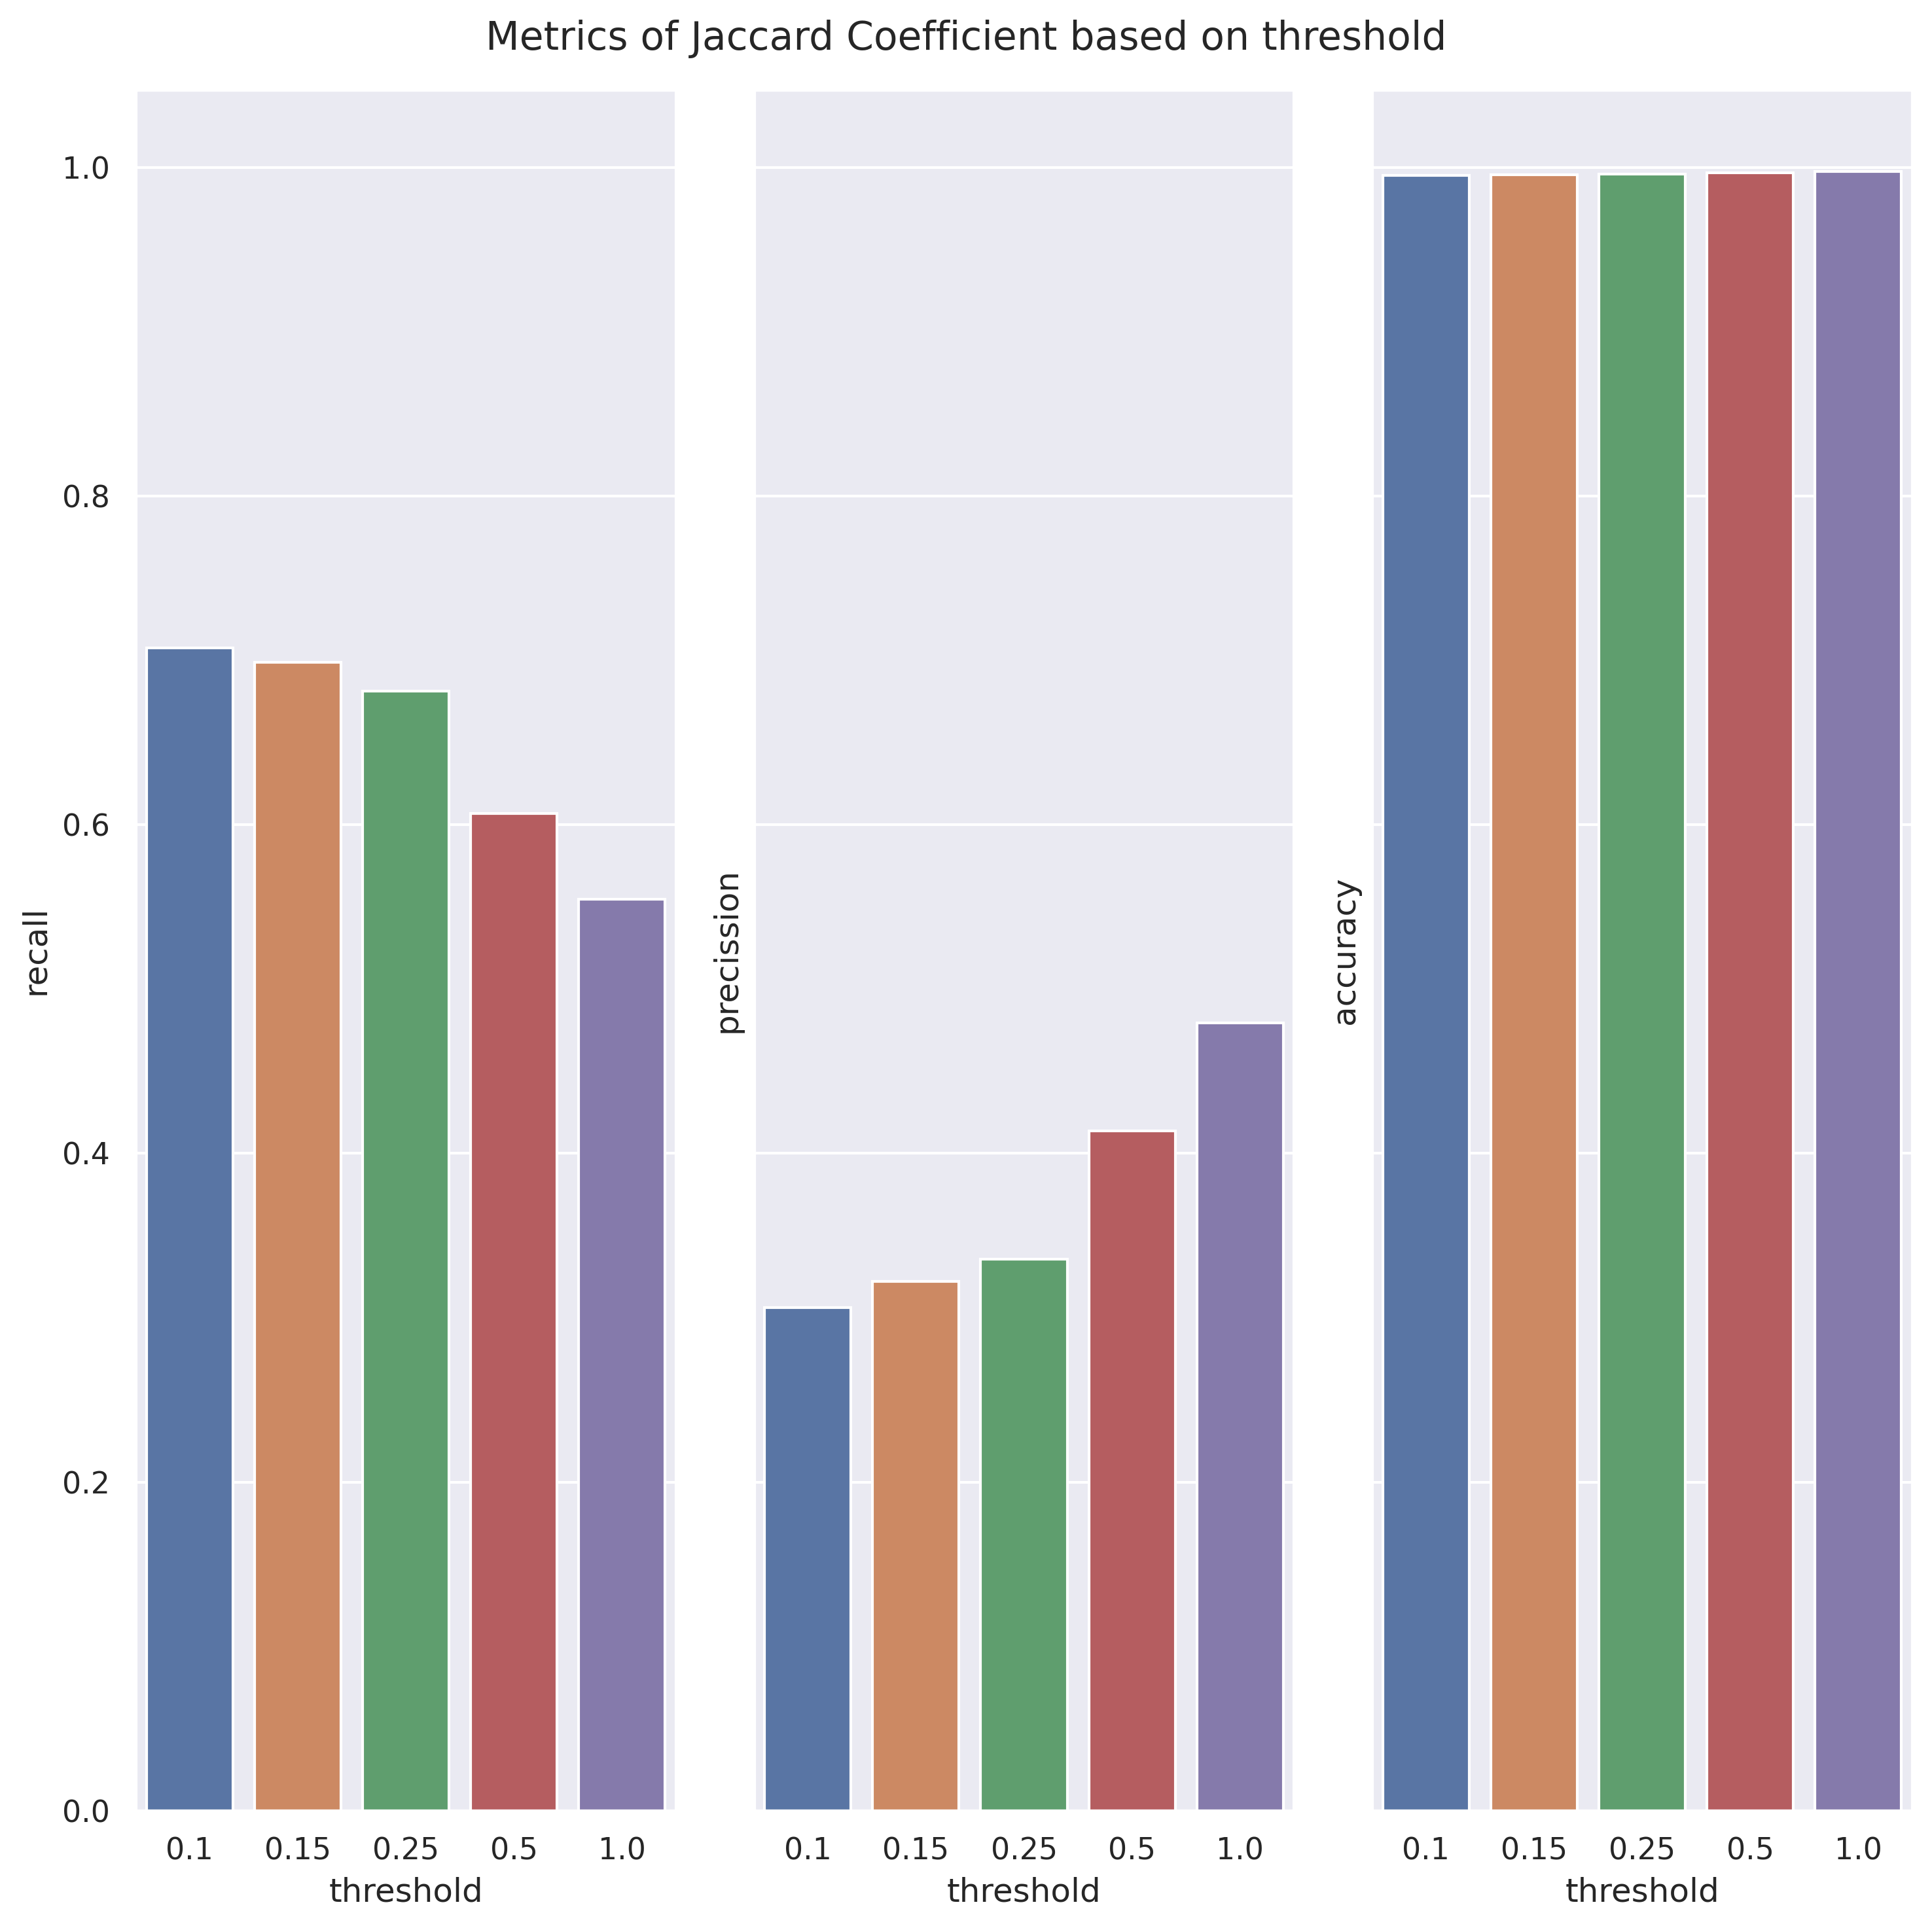

In [58]:
fig, axs = plt.subplots(1, 3, sharey=True)
fig.suptitle('Metrics of Jaccard Coefficient based on threshold')
sns.barplot(data=metrics, x='threshold', y='recall', ax=axs[0])
sns.barplot(data=metrics, x='threshold', y='precission', ax=axs[1])
sns.barplot(data=metrics, x='threshold', y='accuracy', ax=axs[2])
plt.tight_layout()

# Πρόβλεψη συνδέσμων βάσει similarity based μετρικών

## 

## Εξερεύνηση μεθόδων για την συσχέτιση των τιμών το μετρικών.

Σε αυτό το ερώτημα καλούμαστε να εξερευνήσουμε μεθόδους (από τις βιβλιοθήκες NumPy, SciPy, Pandas) ώστε να βρούμε την συσχέτιση μεταξύ των τιμών των μετρικών Jaccard Coefficient, Preferential Attachment και Resource Allocation για τον μειωμένο γράφο G'. Επειδή οι 2 απο τις 3 μετρικές έχουν την ίδια κλίμακα και δεν μας ενδιαφέρει η σειρά των τιμών που υπολογίσαμε αποφασίζουμε να χρησιμοποιήσουμε Linear Correlation αντί για Rank. Ως αποτέλεσμα μια καλή μέθοδος είναι η Pearson Correlation (numpy: numpy.corrcoef, scipy: scipy.stats.pearsonr, pandas: pandas: DataFrame.corr) που χρησιμοποιεί τον τύπο r = Σᵢ((xᵢ − mean(x))(yᵢ − mean(y))) (√Σᵢ(xᵢ − mean(x))² √Σᵢ(yᵢ − mean(y))²)⁻¹. Το r παίρνει τιμές στο διάστημα [-1, 1] και αν είναι 1 ή -1 έχει τέλεια θετική και αντίστοιχα αρνητική συσχέτιση. Αν r = 0 δεν υπάρχει κάποια γραμμική συσχέτιση. Τέλος αν το r > 0 εχει θετική συσχέτιση ενώ αν είναι r < 0 έχει αρνητική. Εδώ πρέπει να αναφέρουμε πως θετική συσχέτιση σημαίνει πως όταν μια τιμή μεγαλώνει, μεγαλώνει και η άλλη τιμή. Ενώ αρνητική σημαίνει οτι όταν μικραίνει μια τιμή, μεγαλώνει η άλλη. Τέλος πρέπει να επιστήσουμε την προσοχή μας στο ότι η ύπαρξη συσχέτισης δεν συνεπάγεται απαραίτητα σχέσεις αιτιότητας μεταξύ των τιμών.

## Δημιουργία αντίγραφου DataFrame

In [59]:
dbpedia_df = unconnected_removable_edges.copy()

dbpedia_df['Jaccard Coefficient'] = dbpedia_df.apply(
    lambda row: list(nx.jaccard_coefficient(dbpedia_removed_G, [row.edges]))[0][2],
    axis=1)
dbpedia_df['Preferential Attachment'] = dbpedia_df.apply(
    lambda row: list(nx.preferential_attachment(dbpedia_removed_G, [row.edges]))[0][2],
    axis=1)
dbpedia_df['Resource Allocation'] = dbpedia_df.apply(lambda row: list(
    nx.resource_allocation_index(dbpedia_removed_G, [row.edges]))[0][2],
                                                     axis=1)

dbpedia_df = dbpedia_df.set_index('edges')

In [60]:
dbpedia_df

,link,Jaccard Coefficient,Preferential Attachment,Resource Allocation
edges,,,,
"(1, 6)",0,0.0,7,0.000000
"(1, 7)",0,0.0,1,0.000000
"(1, 8)",0,0.0,3,0.000000
"(1, 9)",0,0.0,3,0.000000
"(1, 10)",0,0.0,2,0.000000
...,...,...,...,...
"(401, 403)",1,1.0,1,0.166667
"(401, 404)",1,1.0,1,0.166667
"(402, 403)",1,1.0,1,0.166667


## Random Forest Classifier

### Κατασκευή RFC

Χρησιμοποιώντας τον random forest classifier και το παραπάνω dataframe για να προβλέψουμε συνδέσεις.

In [61]:
X = dbpedia_df[dbpedia_df.columns.drop('link')]
y = dbpedia_df['link']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [62]:
classifier = RandomForestClassifier()
mm_scaler = MinMaxScaler()
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

parameters = {'n_estimators': [10, 50, 100], 'max_depth': [5, 10, 15]}
model = GridSearchCV(classifier, param_grid=parameters)

In [63]:
model.fit(X_train_scaled, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [10, 50, 100]})

### Προβλέψεις και ακρίβεια του μοντέλου

Δίνουμε τις πρώτες 10 προβλέψεις και την ακρίβεια του μοντέλου.

In [64]:
predictions = model.predict(X_test_scaled)
predictions[:k]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [65]:
print('Accuracy of model:', accuracy_score(y_test, predictions))

Accuracy of model: 0.9989989118607182


### Πιθανότητα σύνδεσης κόμβων (1, 47)

Υπολογίζουμε την πιθανότητα να συνδεθούν οι κόμβοι (1, 47) βάσει του μοντέλου.

In [66]:
edge1_47 = mm_scaler.transform(dbpedia_df.loc[[
    (1, 47)
]][dbpedia_df.columns.drop('link')])

edge1_47_proba = model.predict_proba(edge1_47)
print("Probability of nodes 1- 47 connecting (link 1): {:.4f}".format(
    edge1_47_proba[0][1]))

Probability of nodes 1- 47 connecting (link 1): 0.0003


# Πρόβλεψη συνδέσμων με embedding βασισμένο σε τυχαίους περιπάτους (Random Walks)

## Εξαγωγή των χαρακτηριστικών του γράφου G'

Με τις δοσμένες παραμέτρους:
| p   | q   | dimensions | num_walks | walk_length | window_size | workers                     |
|-----|-----|------------|-----------|-------------|-------------|-----------------------------|
| 1.0 | 1.0 | 128        | 10        | 80          | 10          | multiprocessing.cpu_count() |

εξάγουμε τα χαρακτηριστικά του G' μέσω του Node2Vec

In [67]:
node2vec_walker = Node2Vec(dbpedia_removed_G,
                           p=1.0,
                           q=1.0,
                           dimensions=128,
                           num_walks=10,
                           walk_length=80,
                           workers=multiprocessing.cpu_count())

n2v_model = node2vec_walker.fit(window=10, min_count=1)

Computing transition probabilities:   0%|          | 0/430 [00:00<?, ?it/s]

Generating walks (CPU: 8): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


## Εφαρμογή RFC

Εφαρμόζουμε τώρα τον Random Forest Classifier ωστε να προβλέψουμε τις συνδέσεις

In [68]:
x = [(n2v_model.wv[str(i)] + n2v_model.wv[str(j)])
     for i, j in unconnected_removable_edges['edges']]

In [69]:
target = unconnected_removable_edges['link']
X_train, X_test, y_train, y_test = train_test_split(x, target, random_state=0)

In [70]:
classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

## Υπολογισμός ακρίβειας μοντέλου

Στη συνέχεια υπολογίζουμε την ακρίβεια του μοντέλου

In [71]:
predictions = classifier.predict(X_test)
print('Accuracy of model:', accuracy_score(y_test, predictions))

Accuracy of model: 0.9987377584330794


## Ερώτηση Bonus

Για τους binary operators για learning των edge features με τον αλγόριθμο Node2Vec που αναφέρονται στο [[3]]("https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf") ((α) Average, (β) Hadamard, (γ) Weighted-L1 και (δ) Weighted-L2) μελετάμε την απόδοση τους

In [72]:
def binary_ops(Embedder):
    edges_embs = Embedder(keyed_vectors=n2v_model.wv)

    x = [
        edges_embs[(str(i), str(j))]
        for i, j in unconnected_removable_edges['edges']
    ]

    target = unconnected_removable_edges['link']
    X_train, X_test, y_train, y_test = train_test_split(x,
                                                        target,
                                                        random_state=0)
    classifier = RandomForestClassifier(max_depth=2, random_state=0)
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    return accuracy_score(y_test, predictions)

table = [[n, binary_ops(e)] for n, e in [("Average", AverageEmbedder), ("Hadamard", HadamardEmbedder),
             ("Weighted- L1", WeightedL1Embedder),
             ("Weighted- L2", WeightedL2Embedder)]]
headers = ["Binary Operator", "Accuracy"]
print(tbl(table, headers))

╒═══════════════════╤════════════╕
│ Binary Operator   │   Accuracy │
╞═══════════════════╪════════════╡
│ Average           │   0.998738 │
├───────────────────┼────────────┤
│ Hadamard          │   0.998738 │
├───────────────────┼────────────┤
│ Weighted- L1      │   0.997606 │
├───────────────────┼────────────┤
│ Weighted- L2      │   0.997606 │
╘═══════════════════╧════════════╛


Παρατηρούμε πως όλα τα μοντέλα που εκπαιδεύσαμε έχουν accuracy 99%. H μόνη διαφορά βρίσκεται στο 3ο δεκαδικό και μετά. Συγκεκριμένα το αρχικό μοντέλο W2V και τα μοντέλα με τους embedders Average και Hadamard εχουν accuracy 99.8% ενώ τα υπόλοιπα, Weighted L1, L2 έχουν accuracy 99.7%. Από τα παραπάνω θα επιλέγαμε το απλό μοντέλο W2V αφού είναι το πιο εύκολο και γρήγορα να υλοποιηθεί προγραμματιστικά και πιο γρήγορο στο runtime αφού δεν καλεί περιττές βιβλιοθήκες και εντολές.

## Βιβλιογραφία

[[1]	Jérôme Kunegis. KONECT - The Koblenz Network Collection. In Proc. Int. Conf. on World Wide Web Companion, pages 1343-1350, 2013.](https://dl.acm.org/doi/10.1145/2487788.2488173")

[[2]	Sören Auer, Christian Bizer, Georgi Kobilarov, Jens Lehmann, Richard Cyganiak, and Zachary Ives. DBpedia: A nucleus for a web of open data. In Proc. Int. Semant. Web Conf., pages 722-735, 2008.](https://link.springer.com/chapter/10.1007/978-3-540-76298-0_52)

[[3] A. Grover, J. Leskovec, Node2vec: Scalable Feature Learning for Networks. ACM KDD, 2016.](https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf)

[[4] T.Mikolov, I.Sutskever, K.Chen, G.S.Corrado and J.Dean, Distributed representations of words and phrases and their compositionality. In NIPS, 2013.](https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf)